In [1]:
import pandas as pd
from sklearn import svm
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from sklearn.neighbors.nca import NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from sklearn import model_selection
from sklearn.model_selection import KFold
import xgboost as xgb
import random
# from imblearn.over_sampling import SMOTE
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from time import time
from sklearn import manifold
from matplotlib.ticker import NullFormatter
import operator, itertools 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Harsh: Use Python[pytorch] kernel <others, please ignore this line>

In [2]:
# ### Considering on dummy data 
# # Input data : 
# # X = num_edges x num_methods, 
# # y = predictions (I - 0/1 values; II - 0/1/2/3 hop connections)

# E = 10000 # number of edges
# M = 6 # number of methods
# X = np.random.rand(E, M)
# y = np.random.choice([0, 1], size=E, p=[.9, .1]) # percentage labels

### Loading the train data: Yeast

In [2]:
df = pd.read_csv('data/yeast-edge-weights-v3.csv', sep=',')

In [3]:
# dropping pcc as not present for test arabidopsis
del df['pcc'] 
# del df['grnboost']
df

,edge,prediction,clr,aracne,grnboost,mrnet,tinge,wgcna
0,YGL035C-YGL209W,1,11.994105,0.523881,90.332360,0.399111,0.525972,2.397206e-01
1,YGL035C-YPL177C,0,-0.301131,0.000242,0.000000,0.000000,0.006223,1.271663e-08
2,YGL035C-YML099C,0,-0.318885,0.000008,0.000000,0.000000,0.004775,5.764450e-11
3,YGL035C-YKR034W,0,-0.200016,0.000008,0.000000,0.000000,0.005317,5.384049e-10
4,YGL035C-YIL119C,0,0.453919,0.007108,0.358562,0.001972,0.016401,1.573763e-05
5,YGL035C-YHR092C,1,5.943508,0.121728,36.166170,0.027365,0.138690,6.528598e-03
6,YGL035C-YPL111W,0,-0.510351,0.000450,0.000000,0.000000,0.004458,3.345493e-12
7,YGL035C-YIR029W,0,2.141256,0.063391,0.000000,0.004767,0.080994,3.815314e-03
8,YGL035C-YJL088W,0,-0.398242,0.000002,0.000000,0.000000,0.003356,2.469381e-23
9,YGL035C-YLR048W,0,-0.441790,0.000338,0.000000,0.000373,0.005448,6.685444e-07


In [4]:
# for c in df.columns:
#     print(c, df[c].value_counts())
df['prediction'].value_counts()

0    1993804
1       5196
Name: prediction, dtype: int64

In [5]:
allOnes = df[df['prediction']==1]
allZeros = df[df['prediction']==0]
numOnes = len(allOnes)
numZeros = len(allZeros)
trainPTS = 20000 # train + valid
testPTS = 200000 # test
# choose 20K points for training
# Randomly choose 200K points for testing
# evenly divide the ones among train/test
df_train = pd.concat([allOnes[:numOnes//2], allZeros[:trainPTS]], ignore_index=True)
df_test = pd.concat([allOnes[numOnes//2:], allZeros[trainPTS: trainPTS+testPTS]], ignore_index=True)

In [6]:
print(df_train.min(axis=0), df_train.max(axis=0))

edge          STA1-YBR112C
prediction               0
clr                 -2.787
aracne                   0
grnboost                 0
mrnet                    0
tinge           0.00180598
wgcna          2.37121e-39
dtype: object edge          YPR065W-YPR201W
prediction                  1
clr                   62.2546
aracne                0.98017
grnboost              1603.52
mrnet                0.998569
tinge                0.969508
wgcna                0.581019
dtype: object


## Visualizing the data
Sometimes it can be helpful, so why not!

In [7]:
def visual2D(X, color):
    Axes3D
    n_points = len(color)
    S = 30 # point size for figures

    n_neighbors = 10
    n_components = 2

    # fig = plt.figure(figsize=(15, 8))
    fig = plt.figure(figsize=(20, 8))
    plt.suptitle("2D projection with %i points, %i neighbors"
                 % (n_points, n_neighbors), fontsize=14)

    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='dense',
                                            method=method).fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (methods[i], t1 - t0))

        ax = fig.add_subplot(252 + i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
        plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    t0 = time()
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print("Isomap: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("Isomap (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print("MDS: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("MDS (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print("SpectralEmbedding: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=5)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("t-SNE (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

standard: 0.66 sec
ltsa: 0.53 sec
hessian: 0.53 sec
modified: 0.51 sec
Isomap: 0.92 sec
MDS: 5.1 sec
SpectralEmbedding: 0.42 sec
t-SNE: 14 sec


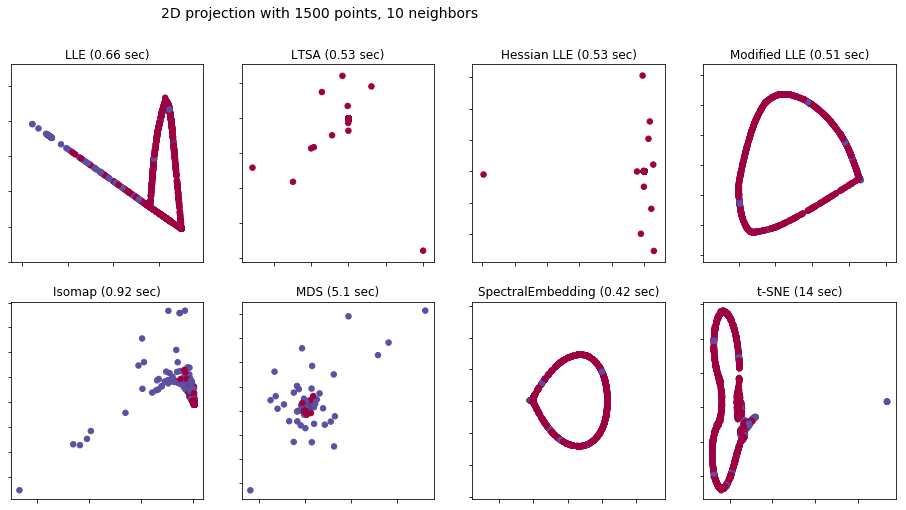

In [8]:
# Visualize the train data: 1500 points
colFeats = [c for c in df_train.columns if c not in ['prediction', 'edge']]

Xviz = np.array(df_train[colFeats])
yviz = np.array(df_train['prediction'])
vizPTS = np.random.choice(len(Xviz), 1500)
#print(Xviz[:vizPTS, :].shape, len(yviz[:vizPTS]), sum(yviz[:vizPTS]))
visual2D(Xviz[vizPTS, :], yviz[vizPTS])

## Binary Classification using traditional ML techniques - XGBoost

In [9]:
clf_VERSION = 'v1'
K = 5 # 5 fold cv

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.array(cm)
        cm = np.around(cm/cm.sum(axis=1)[:, None]*100).astype('int')
        print("Percentage confusion matrix")
        print(cm.sum(axis=1))
    else:
        print('Confusion matrix, without normalization')

#    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def show_confusion_matrix(y, pred_array):
    y = np.array(y).astype(int)
    y_pred = np.array(pred_array)

    cnf_matrix = confusion_matrix(y, y_pred)
    np.set_printoptions(precision=2)
    sorted_cnf_matrix = cnf_matrix
    class_names = ['yes', 'no'] #[0, 1]

    plot_confusion_matrix(sorted_cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    return


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_auc_plot(y, scores):
    y = np.array(y).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
#    print(fpr, tpr, thresholds)
    # Getting accuracy, sensitivity and accuracy plot for varying thresholds. 
    accuracy_array = []
    sensitivity_array = [x*100 for x in tpr]
    specificity_array = [(1-x)*100 for x in fpr]#(1-fpr)*100
    for i, th in enumerate(thresholds):
        pred_array = []
        for s in scores:
            if s>th:
                pred_array.append(1)
            else:
                pred_array.append(0)
        accuracy_array.append(accuracy_score(y, pred_array))
#         print('For threshold : ', th, '->', ' Accuracy ', accuracy_array[i], 
#               ' Sensitivity ', sensitivity_array[i], 'specificity ', specificity_array[i])
#         show_confusion_matrix(y, pred_array)
#     print('accuracy_array', accuracy_array)
#     print('sensitivity_array', sensitivity_array)
#     print('specificity_array', specificity_array)
#     print('thresholds_array', thresholds)
    
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    for i in range(len(fpr)):
        if fpr[i] > 0.01:
            break
    return roc_auc, tpr[i], fpr[i]

def get_auc(y, scores):
    y = np.array(y).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)

#     for i in range(len(fpr)):
#         if fpr[i] > 0.01:
#             break
    return roc_auc#, tpr[i], fpr[i]


def trainXGB(Xtrain, ytrain, Xtest, ytest):
    dtrain = xgb.DMatrix(Xtrain,label=ytrain)
    dtest = xgb.DMatrix(Xtest,label=ytest)
    print('Setting XGB params')
    evallist  = [(dtest,'test'), (dtrain,'train')]
    
    param = {}
    # use softmax multi-class classification
#    param['objective'] = 'multi:softprob'#'multi:softmax'
    param['objective'] = 'binary:logistic' #'multi:softprob'
    # scale weight of positive examples
    param['eta'] = 0.05
    param['max_depth'] = 5
    param['gamma'] = 0
    param['silent'] = 1
    param['nthread'] = 6
    param['subsample'] = 0.5#0.7 # number of examples for 1 tree (subsampled from total)
    param['colsample_bytree'] = 0.5#0.7 # ratio of columns for training 1 tree
#    param['num_class'] = NUM_CLASS
    param['eval_metric'] = 'auc'#'mlogloss' #auc

    # CLASS Imbalance handling!
    param['scale_pos_weight'] = 10#190/10 # sum(negative cases) / sum(positive cases)
    
#    param['booster'] = 'dart' #'gblinear' # default is tree booster
#    param['lambda'] = 1
#    param['alpha'] = 1

    num_round = 220#60
    print('training the XGB classifier')
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=100, verbose_eval=False)
    #print('training completed, printing the relative importance: \
    #      (feature id: importance value)')
    importance = bst.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    #print(importance)
    
    # we will print from df1 dataframe, getting the corresponding feature names. 
    df1 = pd.DataFrame(importance, columns=['feature', 'fscore'])
    # Normalizing the feature scores
    df1['fscore'] = df1['fscore'] / df1['fscore'].sum()
    
    #print(df1)
    # adding a column of feature name
    colFeats = [c for c in df_train.columns if c not in ['prediction', 'edge']]
    # column_names = df_train.columns[:-1]
    df1['feature_names'] = pd.Series([colFeats[int(f[0].replace("f", ""))] for f in importance])
    
    df1.plot()
    df1.plot(kind='barh', x='feature_names', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.gcf().savefig('feature_importance_xgb.png')
    plt.show()
#    print 'Saving the models'
#    bst.save_model(name+'_xgb_v'+clf_VERSION+'.model')
#    bst.dump_model(name+'_xgb_v'+clf_VERSION+'_dump.raw.txt')
#    bst.dump_model(name+'_xgb_v'+clf_VERSION+'_dump.raw.txt',name+'_xgb_v'+clf_VERSION+'_featmap.txt')
    return bst


def classifier_train(X, y, runXGB, Xtest, ytest, pca_comp=0): # pca = 0 means no PCA applied
    print('Normalising the input data...')
    scaler = StandardScaler()#MinMaxScaler()#StandardScaler()
    scaler.fit(X)  
    scaledX = scaler.transform(X)
    if pca_comp != 0:
        pca = PCA(n_components = pca_comp)
        pca.fit(scaledX)
        pca_scaledX = pca.transform(scaledX)
    else:
        pca_scaledX = scaledX
        pca =0

    if runXGB == 1:
        print('Running the XGB classifier')
        clf = trainXGB(pca_scaledX, y, scaler.transform(Xtest), ytest)
        index = 1
    return scaler, pca, clf, index


def classifier_test(X, y, clf, index, scaler, pca):
    scaledX = scaler.transform(X)
    pca_scaledX = scaledX
    if pca != 0:
        pca_scaledX = pca.transform(scaledX)
    if index==1:# XGB
        pca_scaledXG = xgb.DMatrix(pca_scaledX, label=y)
        pred_array = clf.predict(pca_scaledXG, ntree_limit=clf.best_iteration)
        #.reshape(y.shape[0], NUM_CLASS)#, ntree_limit=clf.best_iteration)
        scores = pred_array

#    auc = get_auc(y, scores)

    auc = get_auc_plot(y, scores)
    # Compute confusion matrix
#    show_confusion_matrix(y, pred_array)
    return pred_array, auc# error


def individual_method(data):
    methods = [c for c in data.columns if c not in ['prediction', 'edge']]
    results = {}
    for m in methods:
        auc = get_auc(data['prediction'], data[m])
        results[m] = auc
    print(results)
    return
        
def pandas_classifier(df_train, df_test, runXGB, K=5):
    print('Performing ' + str(K) + '-fold cross validation')
    auc_fold = []
    colFeats = [c for c in df_train.columns if c not in ['prediction', 'edge']]
    print(colFeats)
  
    for k in range(K):# performing K fold validation
        #if k == 0: # running only for k'th fold
            print('Fold_num = ' + str(k))
            #train_rows = [i for i in range(len(df_train)) if i%K!=k]
            datatrain = df_train.loc[[i for i in range(len(df_train)) if i%K!=k]] # training
            #valid_rows = [i for i in range(len(df_train)) if i%K==k]
            datavalid = df_train.loc[[i for i in range(len(df_train)) if i%K==k]] # taking every k'th example
#             Xtrain =  #.iloc[:, 0:-1]
#             ytrain =  #.iloc[:, -1]
#             Xvalid =  #.iloc[:, 0:-1]
#             yvalid = #.iloc[:, -1]
            print('--------------------------------------------------------------')
            print('Calling the classifier to train')
            scaler, pca, clf, index = classifier_train(datatrain[colFeats], datatrain['prediction'], 
                                                       runXGB, datavalid[colFeats], datavalid['prediction'])
            print('Analysing the test predictions for fold num ', k)
            pred_array, auc = classifier_test(datavalid[colFeats],
                                              datavalid['prediction'], clf, index, scaler, 0)
            auc_fold.append(auc[0])
            print('test auc = '+str(auc[0]) )
            individual_method(datavalid)
            print('------------------------------------------------------------')
    if K != 0:
        print('************************************************************************')
        print(auc_fold)#, sum(np.array(auc_fold))/int(K))
        print('Average '+str(K)+' fold CV result= ', str(sum(np.array(auc_fold))/int(K)))
        print('************************************************************************')

#     pred_array, auc = classifier_test(df_test[colFeats], df_test['prediction'], clf, index, scaler, 0)
#     print('TEST AUC on standalone data = ', auc[0])
#     print('individual methods: ', individual_method(df_test))
    return [clf, index, scaler]

Performing 5-fold cross validation
['clr', 'aracne', 'grnboost', 'mrnet', 'tinge', 'wgcna']
Fold_num = 0
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


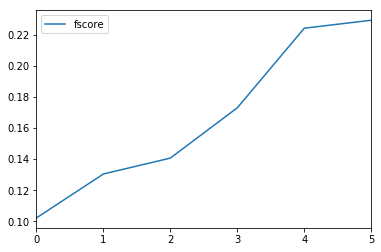

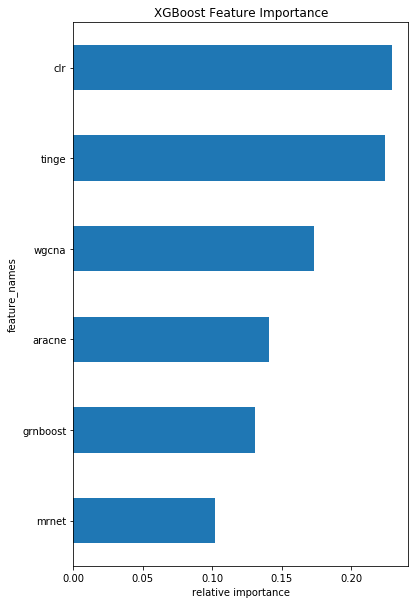

Analysing the test predictions for fold num  0


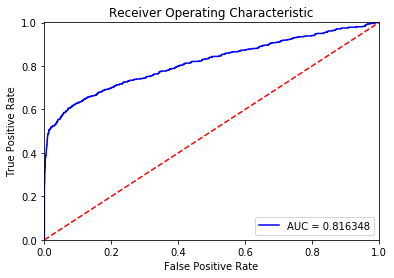

test auc = 0.8163478365384617
{'aracne': 0.7670588942307692, 'wgcna': 0.7782187500000001, 'clr': 0.7912524038461538, 'grnboost': 0.7817129807692308, 'tinge': 0.7751024038461538, 'mrnet': 0.7674822115384615}
------------------------------------------------------------
Fold_num = 1
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


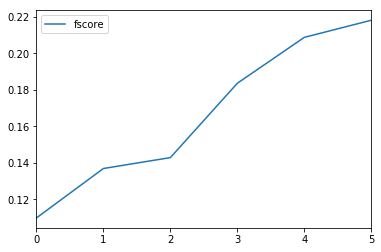

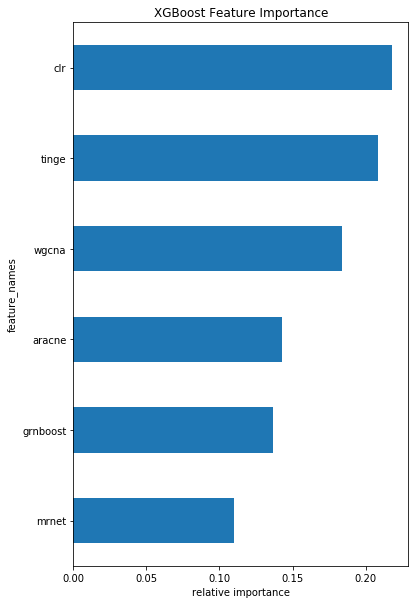

Analysing the test predictions for fold num  1


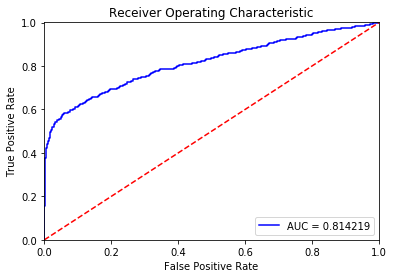

test auc = 0.8142192307692309
{'aracne': 0.765087019230769, 'wgcna': 0.7694201923076923, 'clr': 0.7883319711538462, 'grnboost': 0.7638485576923076, 'tinge': 0.755978846153846, 'mrnet': 0.7687504807692307}
------------------------------------------------------------
Fold_num = 2
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


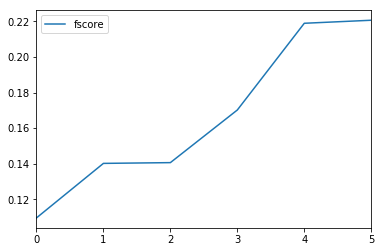

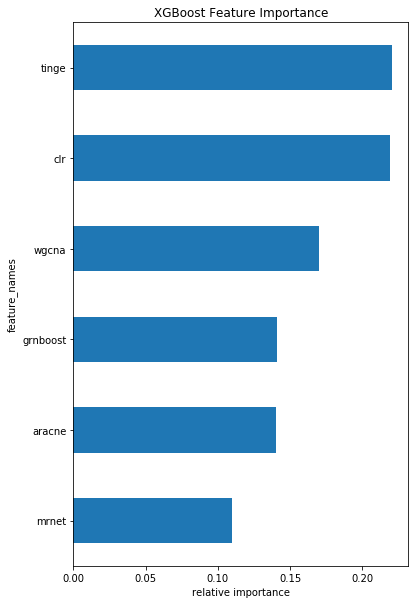

Analysing the test predictions for fold num  2


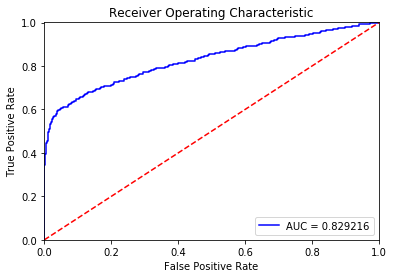

test auc = 0.8292158653846153
{'aracne': 0.7495867788461539, 'wgcna': 0.7785120192307693, 'clr': 0.7931699519230769, 'grnboost': 0.7817343749999999, 'tinge': 0.7635901442307693, 'mrnet': 0.7713533653846154}
------------------------------------------------------------
Fold_num = 3
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


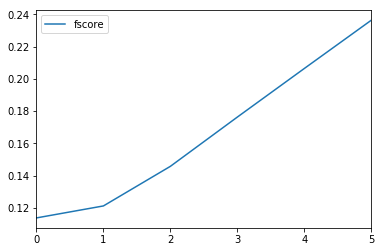

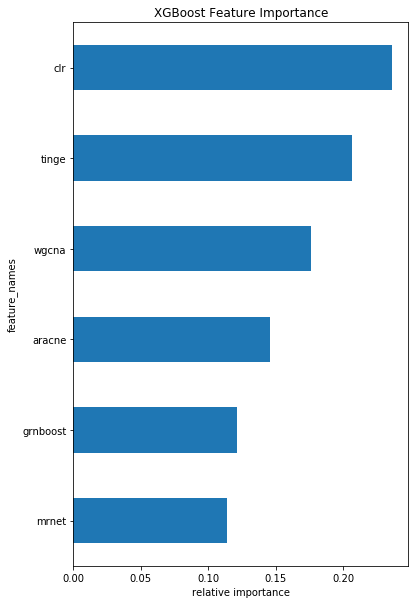

Analysing the test predictions for fold num  3


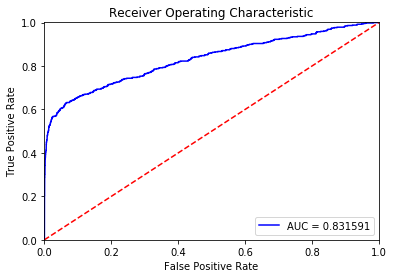

test auc = 0.8315907996146435
{'aracne': 0.7719400289017341, 'wgcna': 0.7894913294797687, 'clr': 0.8090997109826591, 'grnboost': 0.7866842485549134, 'tinge': 0.7862685452793834, 'mrnet': 0.7961741329479768}
------------------------------------------------------------
Fold_num = 4
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


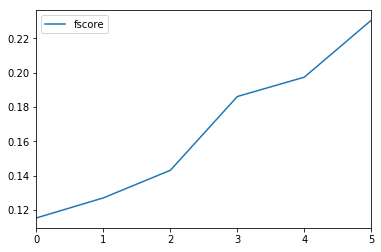

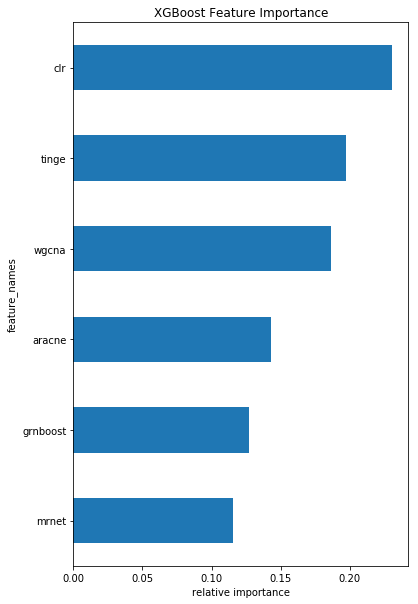

Analysing the test predictions for fold num  4


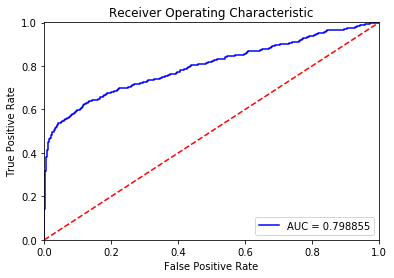

test auc = 0.7988554913294799
{'aracne': 0.7452938342967245, 'wgcna': 0.7636223506743738, 'clr': 0.7894826589595376, 'grnboost': 0.7575582851637764, 'tinge': 0.7615953757225433, 'mrnet': 0.752426782273603}
------------------------------------------------------------
************************************************************************
[0.8163478365384617, 0.8142192307692309, 0.8292158653846153, 0.8315907996146435, 0.7988554913294799]
Average 5 fold CV result=  0.8180458447272863
************************************************************************


In [10]:
# Convert data to pandas before passing 
# np.random.seed(15)
# random.seed(15)
# df_X = pd.DataFrame(X, columns=[c for c in df.columns if c!='prediction'])
# df_y = pd.DataFrame(pd.Series(y, name='label'))
# df_train = pd.concat([df_X, df_y], axis=1)
# df_test

#print(df_classifier, df)
#print(df.columns)

trained_params = pandas_classifier(df_train, df_test, 1)

In [11]:
print('individual methods on test: ', individual_method(df_test))

{'aracne': 0.8183966887990762, 'wgcna': 0.8307770246343341, 'clr': 0.8452145679368746, 'grnboost': 0.8162518851039262, 'tinge': 0.8359971218244804, 'mrnet': 0.8312013433410317}
individual methods:  None


### Loading the arabidopsis data

In [13]:
abdOnes  = pd.read_csv('data/true_network_positive_edges.csv', sep=',')
abdOnes['prediction'] = 1
abdZeros = pd.read_csv('data/true_network_negative_edges.csv', sep=',')
abdZeros['prediction'] = 0
df_abd   = pd.concat([abdOnes, abdZeros], ignore_index=True)
#del df_abd['grnboost']
df_abd

,edge,clr,aracne,mrnet,tinge,wgcna,prediction
0,AT3G04720-AT5G47220,8.116924,0.261874,NaN,NaN,NaN,1
1,AT1G06160-AT5G44420,21.420513,0.322081,NaN,0.155903,NaN,1
2,AT1G06160-AT5G47220,19.946568,0.416314,0.080131,0.231226,NaN,1
3,AT2G14610-AT3G56400,12.730006,NaN,NaN,NaN,NaN,1
4,AT2G14610-AT5G06960,9.886962,NaN,NaN,NaN,NaN,1
5,AT2G14610-AT5G22570,20.710621,0.439876,NaN,0.168890,0.053627,1
6,AT2G14610-AT3G12250,9.703717,NaN,NaN,NaN,NaN,1
7,AT2G14560-AT3G56400,22.501108,0.571406,0.106716,0.465828,0.147370,1
8,AT1G75040-AT3G56400,8.211739,NaN,NaN,NaN,NaN,1
9,AT1G52690-AT5G05410,8.990657,0.239686,NaN,0.108993,NaN,1


In [14]:
# # Imputation step with zeros
df_abd = df_abd.fillna(0) # DOES NOT work that well


# # Imputation with the min values of the big file Arabidopsis
# colFeats = [c for c in df_abd.columns if c not in ['prediction', 'edge']]
# for c in colFeats:
#     df_abd[c] = df_abd[c].fillna(minAbd_vals[c])
# print(minAbd_vals)

# # Imputation with the min values of the train data in yeast
# minYeast_vals = df_train.min(axis=0)
# colFeats = [c for c in df_abd.columns if c not in ['prediction', 'edge']]
# for c in colFeats:
#     df_abd[c] = df_abd[c].fillna(minYeast_vals[c])


# # Scaling the test data in the ranges similar to training of Yeast
# minYeast = df_train.min(axis=0)
# maxYeast = df_train.max(axis=0)
# minAbd = df_abd.min(axis=0)
# maxAbd = df_abd.max(axis=0)
# colFeats = [c for c in df_abd.columns if c not in ['prediction', 'edge']]
# for c in colFeats:
#     df_abd[c] = df_abd[c].fillna(minYeast_vals[c])
#     # (x-min)/(max-min)*(b-a) + a
#     df_abd[c] = (df_abd[c] - df_abd[c].min())/(df_abd[c].max()-df_abd[c].min())*(maxYeast[c]-minYeast[c]) + minYeast[c]
    

df_abd

,edge,clr,aracne,mrnet,tinge,wgcna,prediction
0,AT3G04720-AT5G47220,8.116924,0.261874,0.000000,0.000000,0.000000,1
1,AT1G06160-AT5G44420,21.420513,0.322081,0.000000,0.155903,0.000000,1
2,AT1G06160-AT5G47220,19.946568,0.416314,0.080131,0.231226,0.000000,1
3,AT2G14610-AT3G56400,12.730006,0.000000,0.000000,0.000000,0.000000,1
4,AT2G14610-AT5G06960,9.886962,0.000000,0.000000,0.000000,0.000000,1
5,AT2G14610-AT5G22570,20.710621,0.439876,0.000000,0.168890,0.053627,1
6,AT2G14610-AT3G12250,9.703717,0.000000,0.000000,0.000000,0.000000,1
7,AT2G14560-AT3G56400,22.501108,0.571406,0.106716,0.465828,0.147370,1
8,AT1G75040-AT3G56400,8.211739,0.000000,0.000000,0.000000,0.000000,1
9,AT1G52690-AT5G05410,8.990657,0.239686,0.000000,0.108993,0.000000,1


Check col order:  ['clr', 'aracne', 'mrnet', 'tinge', 'wgcna']


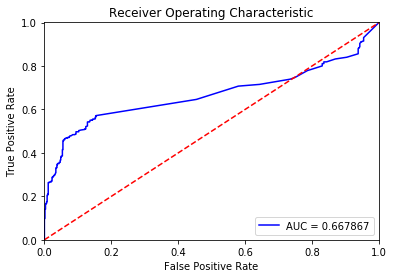

ENSEMBLE AUC on Arabidopsis data =  0.6678672291912122
individual methods on arabidopsis: 
{'tinge': 0.6973737785016287, 'aracne': 0.7068620486520202, 'mrnet': 0.6480330410977893, 'clr': 0.5384988564696098, 'wgcna': 0.601063829787234}


In [15]:
# predicting using the trained params
clf, index, scaler = trained_params

print('Check col order: ', colFeats)
pred_array, auc = classifier_test(df_abd[colFeats], df_abd['prediction'], clf, index, scaler, 0)
print('ENSEMBLE AUC on Arabidopsis data = ', auc[0])
print('individual methods on arabidopsis: ')
individual_method(df_abd)

## RESULTS: imputation with zeros
ENSEMBLE AUC on Arabidopsis data =  0.7127507970060296  
individual methods on arabidopsis:   
{'aracne': 0.7068620486520202, 'tinge': 0.6973737785016287, 'wgcna': 0.601063829787234, 'grnboost': 0.7553862880310486, 'mrnet': 0.6480330410977893, 'clr': 0.5384988564696098}

## RESULTS: Imputation with min value from the big arabidopsis file
ENSEMBLE AUC on Arabidopsis data =  0.641143703652367  
individual methods on arabidopsis:   
{'aracne': 0.7068620486520202, 'tinge': 0.6973737785016287, 'wgcna': 0.601063829787234, 'grnboost': 0.7553862880310486, 'mrnet': 0.6480330410977893, 'clr': 0.5384988564696098}

## Finding values for imputation 
Less than the minimum value given in the big predictions file

In [22]:
df_fullAbd = pd.read_csv('data/arabidopsis-edges-final-test-v1.csv', sep=',')

In [23]:
df_fullAbd

,edge,clr,aracne,grnboost,mrnet,tinge,wgcna
0,AT2G26020-AT5G44420,140.356384,1.017074,98970.57000,0.796014,0.863873,0.510619
1,AT2G26020-AT4G12480,7.550184,NaN,NaN,NaN,NaN,NaN
2,AT2G26020-AT3G46230,7.599510,NaN,NaN,NaN,NaN,NaN
3,AT2G26020-AT4G16260,19.837782,NaN,7735.48800,NaN,NaN,NaN
4,AT2G26020-AT3G21370,9.057870,NaN,1662.81250,NaN,NaN,NaN
5,AT2G26020-AT3G22231,8.275023,NaN,564.43823,0.065384,NaN,0.054316
6,AT2G26020-AT5G66400,8.135590,NaN,874.35333,NaN,NaN,NaN
7,AT2G26020-AT5G61160,33.755291,0.312848,18730.32400,0.077677,0.234179,NaN
8,AT2G26020-AT3G57260,7.621652,NaN,504.40262,NaN,NaN,NaN
9,AT2G26020-AT4G24350,15.134204,0.244278,4393.84500,NaN,NaN,NaN


In [25]:
minAbd_vals = df_fullAbd.min(axis=0)

In [26]:
minAbd_vals

edge        AT1G01010-AT1G01340
clr                         7.5
aracne                0.0444187
grnboost                    410
mrnet                     0.065
tinge                0.00833519
wgcna                      0.05
dtype: object

In [34]:
maxAbd_vals = df_fullAbd.max(axis=0)
maxAbd_vals

edge        ATMG01400-ATMG01410
clr                     140.356
aracne                  1.52231
grnboost                98970.6
mrnet                   1.25616
tinge                   1.12868
wgcna                  0.818924
dtype: object

In [ ]:
# df_train yeast

edge          STA1-YBR112C
clr                 -2.787
aracne                   0
grnboost                 0
mrnet                    0
tinge           0.00180598
wgcna          2.37121e-39
dtype: object
    
edge          YPR065W-YPR201W
clr                   62.2546
aracne                0.98017
grnboost              1603.52
mrnet                0.998569
tinge                0.969508
wgcna                0.581019
dtype: object

In [62]:
df_abd['clr'].min()

0.0

## Loading the athaliana_raw data

******************************************
ath type:  chemical


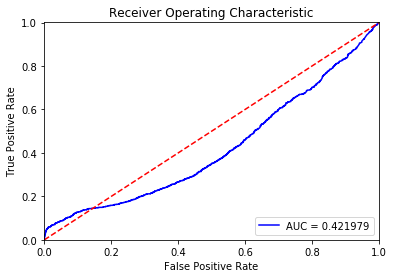

ENSEMBLE AUC on Arabidopsis data =  0.42197896135982566
individual methods on arabidopsis: 
{'aracne': 0.5088917679408057, 'wgcna': 0.47690163281561126, 'clr': 0.46932208473798087, 'grnboost': 0.520782601140967, 'tinge': 0.5070733359206752, 'mrnet': 0.38999992390171145}
******************************************
ath type:  development


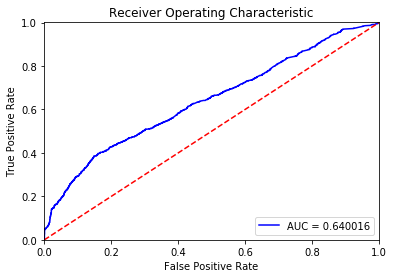

ENSEMBLE AUC on Arabidopsis data =  0.6400157024550255
individual methods on arabidopsis: 
{'aracne': 0.5374229586808468, 'wgcna': 0.6463524582125924, 'clr': 0.6798306500644768, 'grnboost': 0.5606447567774296, 'tinge': 0.5267963743386828, 'mrnet': 0.6084073101608736}
******************************************
ath type:  flower


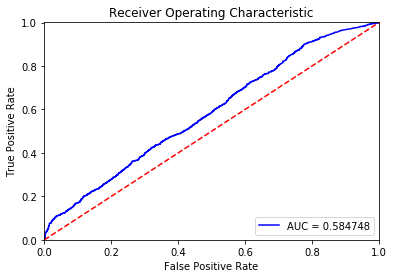

ENSEMBLE AUC on Arabidopsis data =  0.5847479627079618
individual methods on arabidopsis: 
{'aracne': 0.5181265064924967, 'wgcna': 0.5675711265115089, 'clr': 0.6189230820359627, 'grnboost': 0.5352056793356258, 'tinge': 0.5191185028004144, 'mrnet': 0.5507424609534701}
******************************************
ath type:  hormone-aba-iaa-ga-br


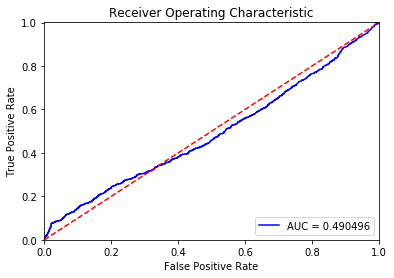

ENSEMBLE AUC on Arabidopsis data =  0.49049608799258937
individual methods on arabidopsis: 
{'aracne': 0.5099245508202125, 'wgcna': 0.5150277036842112, 'clr': 0.513592016235462, 'grnboost': 0.5263297967776275, 'tinge': 0.5070623130217283, 'mrnet': 0.4981734108425136}
******************************************
ath type:  hormone-ja-sa-ethylene


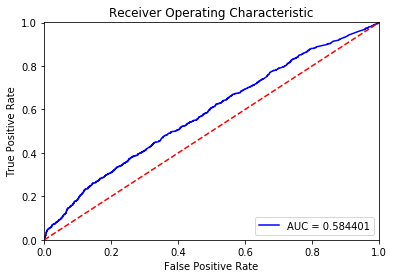

ENSEMBLE AUC on Arabidopsis data =  0.584401061990237
individual methods on arabidopsis: 
{'aracne': 0.5066286400710034, 'wgcna': 0.615359072059251, 'clr': 0.5984846745933373, 'grnboost': 0.5185876983580469, 'tinge': 0.5089278336317311, 'mrnet': 0.5746409661968812}
******************************************
ath type:  leaf


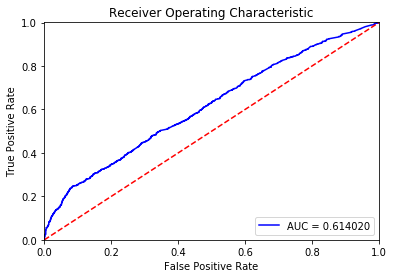

ENSEMBLE AUC on Arabidopsis data =  0.6140195817827396
individual methods on arabidopsis: 
{'aracne': 0.5107005729812747, 'wgcna': 0.6517916740504459, 'clr': 0.6394146139760175, 'grnboost': 0.5276487462342725, 'tinge': 0.5082713095870991, 'mrnet': 0.6306818181818182}
******************************************
ath type:  light


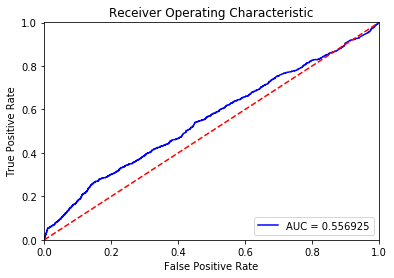

ENSEMBLE AUC on Arabidopsis data =  0.5569248519679555
individual methods on arabidopsis: 
{'aracne': 0.5077303204458378, 'wgcna': 0.5883214327179844, 'clr': 0.5336673124927436, 'grnboost': 0.5208503860443516, 'tinge': 0.5096598165563684, 'mrnet': 0.6048781638221293}
******************************************
ath type:  nutrients


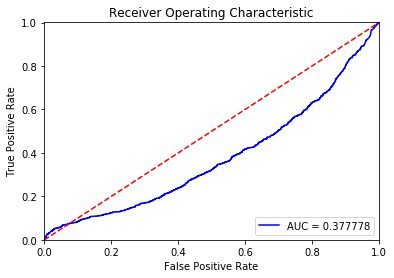

ENSEMBLE AUC on Arabidopsis data =  0.37777802912626235
individual methods on arabidopsis: 
{'aracne': 0.5096379576427533, 'wgcna': 0.4890368074720878, 'clr': 0.41885245592604325, 'grnboost': 0.5108830751984397, 'tinge': 0.5040972944849116, 'mrnet': 0.40133833642491973}
******************************************
ath type:  root


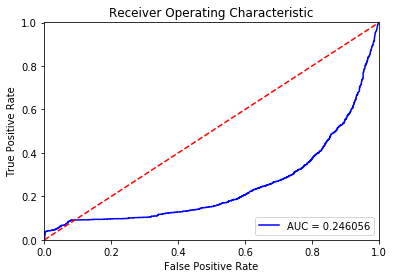

ENSEMBLE AUC on Arabidopsis data =  0.2460557243779544
individual methods on arabidopsis: 
{'aracne': 0.5219847345592437, 'wgcna': 0.26629655602306374, 'clr': 0.2506170134019012, 'grnboost': 0.5069098683185289, 'tinge': 0.520894369123682, 'mrnet': 0.26280193236714977}
******************************************
ath type:  rosette


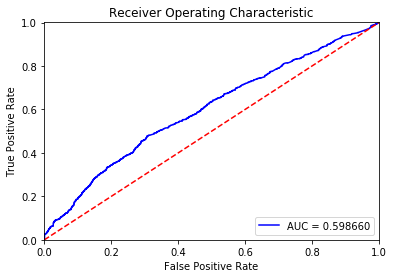

ENSEMBLE AUC on Arabidopsis data =  0.5986602932838733
individual methods on arabidopsis: 
{'aracne': 0.5105652637816925, 'wgcna': 0.6292084412420831, 'clr': 0.6016090868426825, 'grnboost': 0.5300876660655116, 'tinge': 0.5130044288884901, 'mrnet': 0.6333128912137348}
******************************************
ath type:  seed


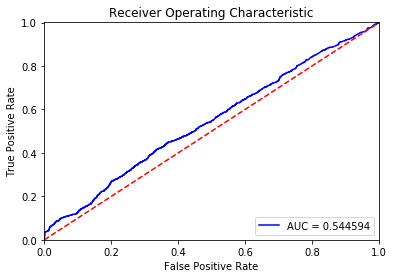

ENSEMBLE AUC on Arabidopsis data =  0.5445944155467377
individual methods on arabidopsis: 
{'aracne': 0.5190452163444516, 'wgcna': 0.5491512298087269, 'clr': 0.5794638390317783, 'grnboost': 0.5249434038985632, 'tinge': 0.5172772306630938, 'mrnet': 0.5541549305427058}
******************************************
ath type:  seedling1wk


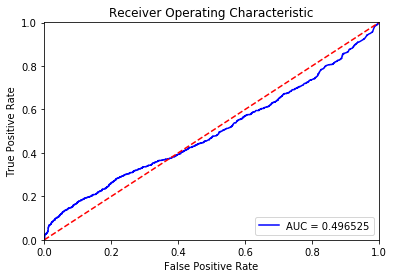

ENSEMBLE AUC on Arabidopsis data =  0.4965252262713684
individual methods on arabidopsis: 
{'aracne': 0.5122459077617203, 'wgcna': 0.5143568540644174, 'clr': 0.48956207077992175, 'grnboost': 0.5329873868643158, 'tinge': 0.5115275169571226, 'mrnet': 0.5431004242682657}
******************************************
ath type:  seedling2wk


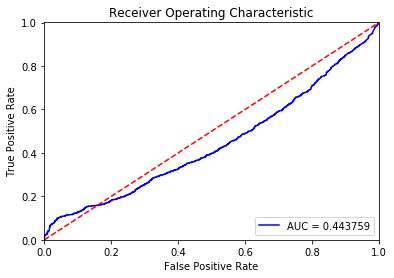

ENSEMBLE AUC on Arabidopsis data =  0.4437593320374127
individual methods on arabidopsis: 
{'aracne': 0.5145143114717152, 'wgcna': 0.4282380409060176, 'clr': 0.4579040596123507, 'grnboost': 0.5316472278566599, 'tinge': 0.5116558908045977, 'mrnet': 0.44536409032003604}
******************************************
ath type:  shoot


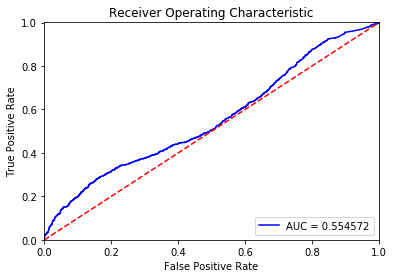

ENSEMBLE AUC on Arabidopsis data =  0.5545715234178996
individual methods on arabidopsis: 
{'aracne': 0.515665347994762, 'wgcna': 0.5326700199483545, 'clr': 0.602297655762382, 'grnboost': 0.530328115247641, 'tinge': 0.5116035861144766, 'mrnet': 0.5026078955097845}
******************************************
ath type:  stress-light


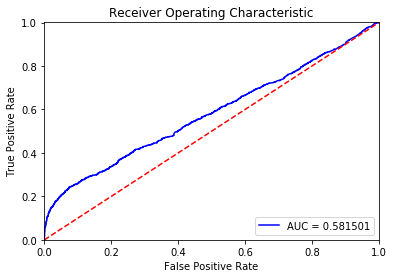

ENSEMBLE AUC on Arabidopsis data =  0.5815007962676356
individual methods on arabidopsis: 
{'aracne': 0.5060422881666404, 'wgcna': 0.6179186386440272, 'clr': 0.614464781045092, 'grnboost': 0.5229469005375741, 'tinge': 0.5071512684206986, 'mrnet': 0.5989042908732027}
******************************************
ath type:  stress-other


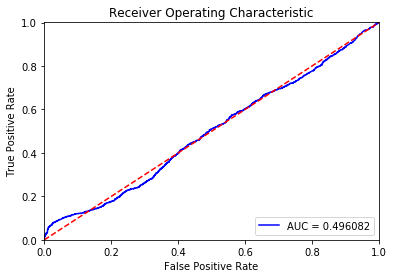

ENSEMBLE AUC on Arabidopsis data =  0.496082321293615
individual methods on arabidopsis: 
{'aracne': 0.5071123382794203, 'wgcna': 0.57624001366846, 'clr': 0.5640518877689731, 'grnboost': 0.5154216021530318, 'tinge': 0.5075531960002295, 'mrnet': 0.5217491887469664}
******************************************
ath type:  stress-pathogen


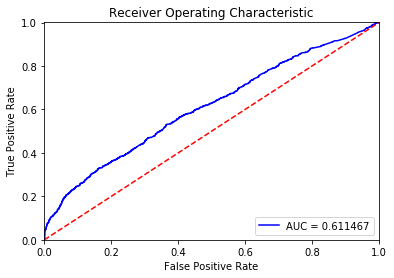

ENSEMBLE AUC on Arabidopsis data =  0.6114665283265175
individual methods on arabidopsis: 
{'aracne': 0.5103072797532405, 'wgcna': 0.6460795441417713, 'clr': 0.6064365353734895, 'grnboost': 0.5234362364547954, 'tinge': 0.507513400799427, 'mrnet': 0.6471416441394608}
******************************************
ath type:  stress-salt-drought


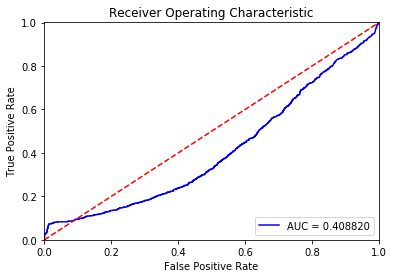

ENSEMBLE AUC on Arabidopsis data =  0.40882035470443023
individual methods on arabidopsis: 
{'aracne': 0.5126464808445147, 'wgcna': 0.5104002045179883, 'clr': 0.41204435354756075, 'grnboost': 0.5297004599072438, 'tinge': 0.5110005887639056, 'mrnet': 0.4165162478179583}
******************************************
ath type:  stress-temperature


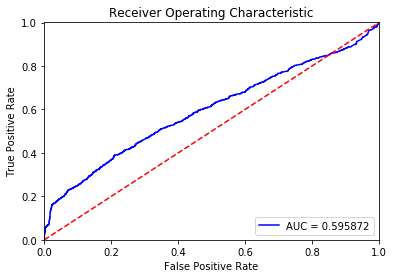

ENSEMBLE AUC on Arabidopsis data =  0.5958721962624001
individual methods on arabidopsis: 
{'aracne': 0.5103146130757628, 'wgcna': 0.6419814103095824, 'clr': 0.6302391990242793, 'grnboost': 0.5284160207432804, 'tinge': 0.5071673686571245, 'mrnet': 0.6192320040061075}
******************************************
ath type:  wholeplant


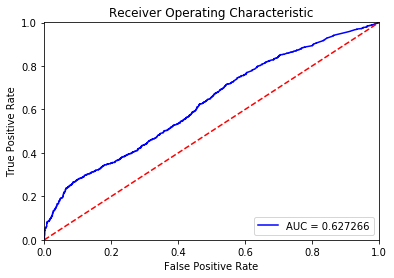

ENSEMBLE AUC on Arabidopsis data =  0.6272660931567632
individual methods on arabidopsis: 
{'aracne': 0.5104466858789626, 'wgcna': 0.6093010240839852, 'clr': 0.648118367183569, 'grnboost': 0.5255844097365171, 'tinge': 0.5100864553314121, 'mrnet': 0.5927082618590184}


In [18]:
ath_types = ['chemical', 'development', 'flower', 'hormone-aba-iaa-ga-br' ,'hormone-ja-sa-ethylene',
            'leaf', 'light', 'nutrients', 'root', 'rosette', 'seed', 'seedling1wk', 'seedling2wk',
            'shoot', 'stress-light', 'stress-other', 'stress-pathogen', 'stress-salt-drought', 
            'stress-temperature', 'wholeplant']

# predicting using the trained params
clf, index, scaler = trained_params

for i, t in enumerate(ath_types):
    print('******************************************')
    print('ath type: ', t)
    athOnes  = pd.read_csv('data/athaliana_raw/'+ath_types[i]+'-positives.csv', sep=',')
    athOnes['prediction'] = 1
    athZeros = pd.read_csv('data/athaliana_raw/'+ath_types[i]+'-negatives.csv', sep=',')
    athZeros['prediction'] = 0
    df_ath   = pd.concat([athOnes, athZeros], ignore_index=True)
    #del df_abd['grnboost']
    # print(df_ath)
    # # Imputation step with zeros
    df_ath = df_ath.fillna(0)


    #print('Check col order: ', colFeats)
    pred_array, auc = classifier_test(df_ath[colFeats], df_ath['prediction'], clf, index, scaler, 0)
    print('ENSEMBLE AUC on Arabidopsis data = ', auc[0])
    print('individual methods on arabidopsis: ')
    individual_method(df_ath)